<img align="right" src="./images/occiput_logo3.png" width="200">

# Simulator of Siemens Biograph mMR PET-MR scanner

#### This notebook shows how to simulate PET acquisition and reconstruction using the Siemens Biograph mMR geometry  

# SIMULATION

In [1]:
import occiput
from occiput.Reconstruction.PET.PET_scanners import Biograph_mMR

import numpy as np
import scipy.io as io

In [2]:
sim_path = '../../Douglas/simulation/01'

## Set scanner geometry and characteristics

In [3]:
pet = occiput.Reconstruction.PET.PET_Static_Scan()
pet.set_scanner(Biograph_mMR) 

In [4]:
pet.use_compression(False) 

In [5]:
pet.import_sensitivity('%s/norm3d_00.h33'%sim_path) 

In [6]:
pet.sensitivity.data.shape

(252, 11, 344, 127)

## Load activity phantom and attenuation phantom

#### Change the files here to change groundtruth activity and attenuation. Or change the variable simulation_path; in this case the new path must contains the required nifti files with the activity and attenuation phantoms. 

In [7]:
true_activity = occiput.DataSources.FileSources.import_nifti('%s/true_activity.nii'%sim_path)
attenuation   = occiput.DataSources.FileSources.import_nifti('%s/attenuation.nii'%sim_path)

print true_activity.shape
print attenuation.shape

(344, 344, 127)
(344, 344, 127)


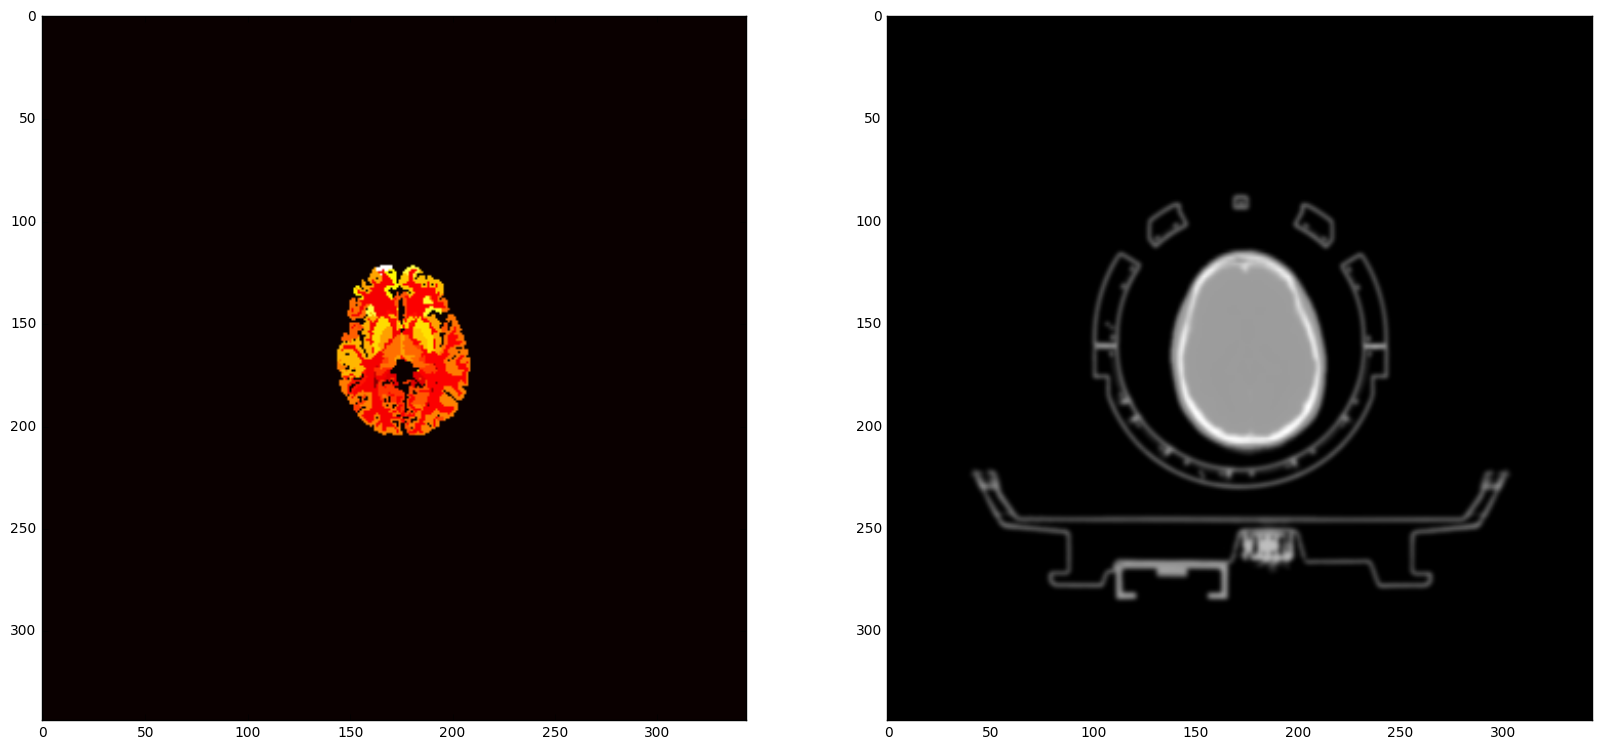

In [8]:
figure(figsize=[20,10])
subplot(1,2,1); imshow(flipud(true_activity.data[:,:,64]),cmap='hot') 
subplot(1,2,2); imshow(flipud(attenuation.data[:,:,64]),cmap='gray') 

## Simulate PET acquisition

#### 1- Compute noiseless prompts in the ideal case (no scatter, no randoms)

In [9]:
# Set the discretization grid for the attenuation:
pet.set_attenuation_shape(attenuation.shape)
pet.set_attenuation_size([2.08626*pet.attenuation_shape[0], 2.08626*pet.attenuation_shape[1], 2.03125*pet.attenuation_shape[2]])
attenuation_projection = pet.project_attenuation(attenuation)

# Set the discretization grid for the activity: 
pet.set_activity_shape(true_activity.shape)
pet.set_activity_size([2.08626*pet.activity_shape[0], 2.08626*pet.activity_shape[1], 2.03125*pet.activity_shape[2]])
ideal_prompts = pet.project_activity(true_activity) 

#### 2- Add expected randoms and scatter 

In [10]:
randoms = occiput.DataSources.FileSources.import_PET_Projection('%s/randoms.h5'%sim_path)
scatter = occiput.DataSources.FileSources.import_PET_Projection('%s/scatter.h5'%sim_path)
# NOTE: the randoms and scatter stored in the .h5 files above have been generated with an old version of occiput. The
# line below make them compatible. 
randoms.sparsity = ideal_prompts.sparsity
scatter.sparsity = ideal_prompts.sparsity

#### 3- Set scan duration and apply Poisson noise

In [11]:
acquisition_time_sec = 20*60
counts_per_sec       = 5e5

scale = acquisition_time_sec * counts_per_sec / ideal_prompts.data.sum()

randoms.data = randoms.data * scale
scatter.data = 10*scatter.data * scale 

import copy
prompts = copy.deepcopy(ideal_prompts)
prompts.data = ideal_prompts.data * scale * attenuation_projection.data * pet.sensitivity.data + randoms.data + scatter.data * pet.sensitivity.data

noisy_prompts = copy.deepcopy(prompts)
noisy_prompts.data = float32(np.random.poisson(prompts.data))

print true_activity.data.max(), true_activity.data.mean()
print scale
print pet.scale_activity

7.69617 0.0355924
0.195925829482
3.432e-05


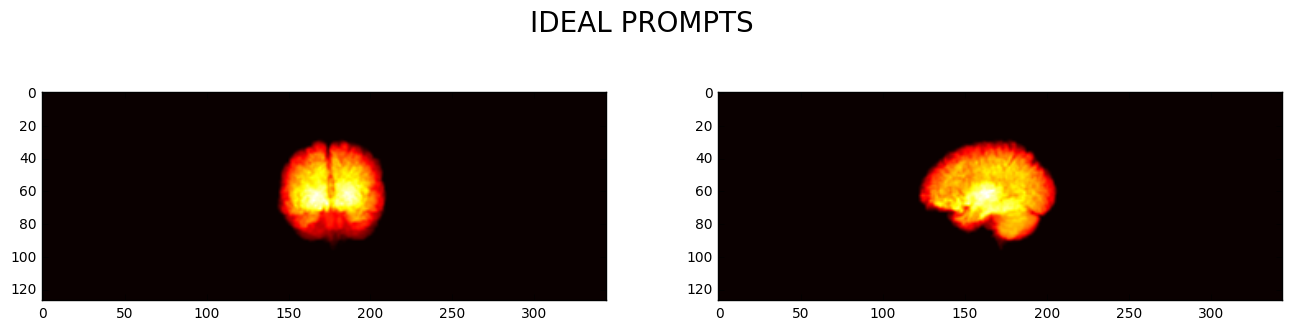

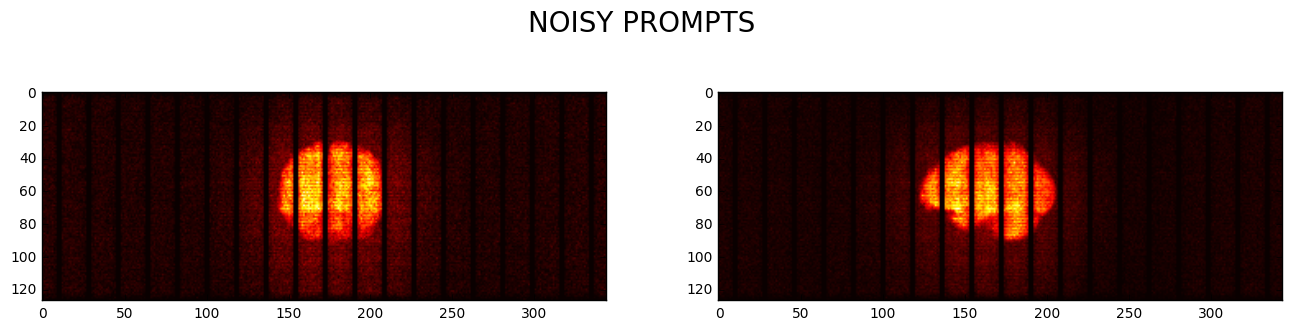

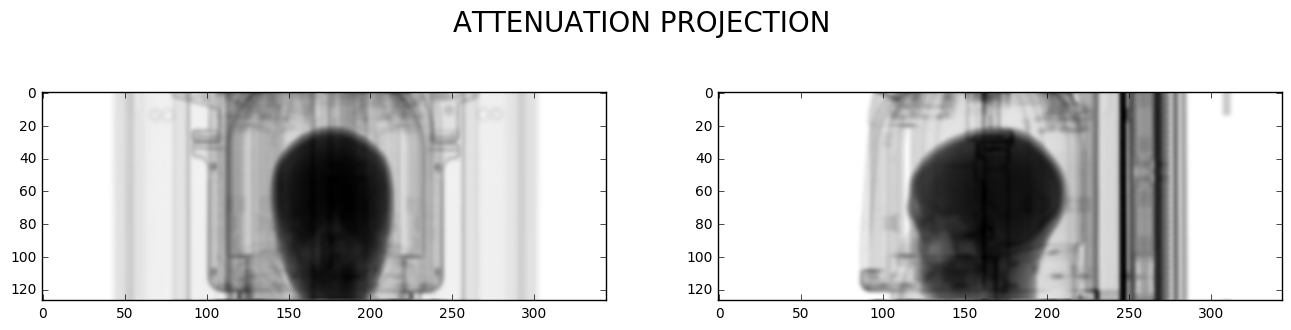

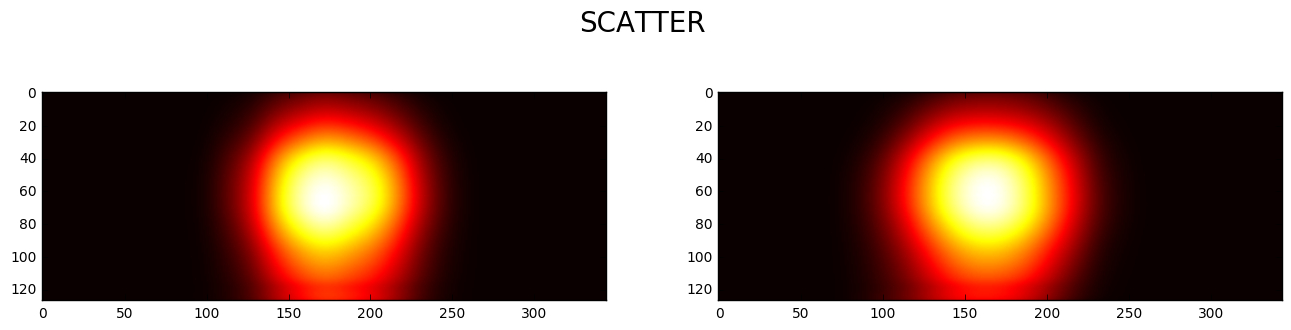

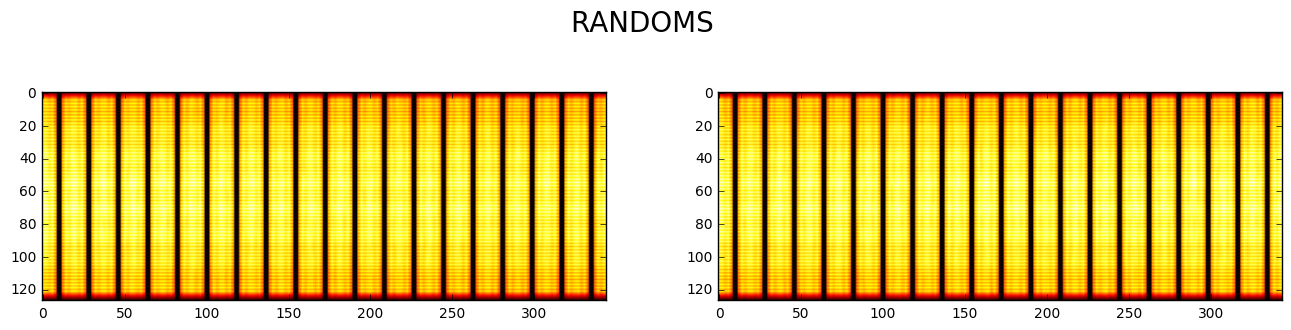

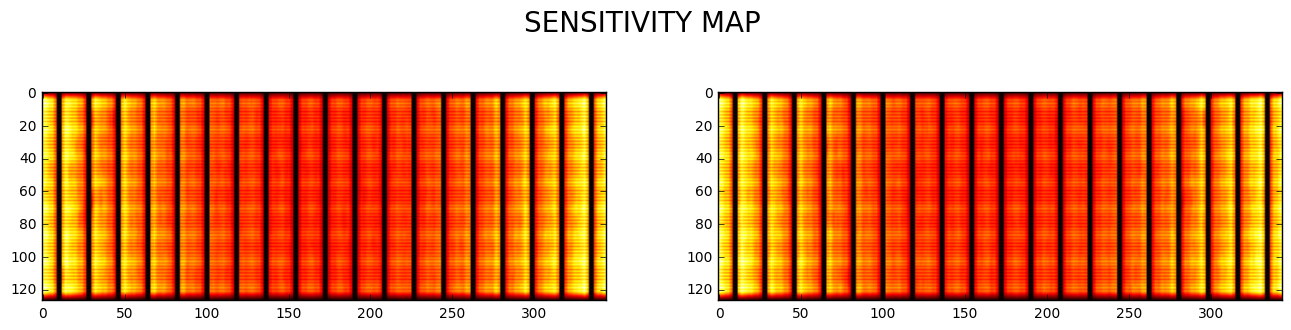

In [12]:
figure(figsize=[16,4])
subplot(1,2,1); imshow(flipud(ideal_prompts.to_nd_array()[0,5,:,:].T), cmap="hot")
subplot(1,2,2); imshow(flipud(ideal_prompts.to_nd_array()[126,5,:,:].T), cmap="hot")
suptitle("IDEAL PROMPTS", fontsize=20)
figure(figsize=[16,4])
subplot(1,2,1); imshow(flipud(noisy_prompts.to_nd_array()[0,5,:,:].T), cmap="hot")
subplot(1,2,2); imshow(flipud(noisy_prompts.to_nd_array()[126,5,:,:].T), cmap="hot")
suptitle("NOISY PROMPTS", fontsize=20)
figure(figsize=[16,4])
subplot(1,2,1); imshow(flipud(attenuation_projection.to_nd_array()[0,5,:,:].T), cmap="gray")
subplot(1,2,2); imshow(flipud(attenuation_projection.to_nd_array()[126,5,:,:].T), cmap="gray")
suptitle("ATTENUATION PROJECTION", fontsize=20)
figure(figsize=[16,4])
subplot(1,2,1); imshow(flipud(scatter.to_nd_array()[0,5,:,:].T), cmap="hot")
subplot(1,2,2); imshow(flipud(scatter.to_nd_array()[126,5,:,:].T), cmap="hot")
suptitle("SCATTER", fontsize=20)
figure(figsize=[16,4])
subplot(1,2,1); imshow(flipud(randoms.to_nd_array()[0,5,:,:].T), cmap="hot")
subplot(1,2,2); imshow(flipud(randoms.to_nd_array()[126,5,:,:].T), cmap="hot")
suptitle("RANDOMS", fontsize=20)
figure(figsize=[16,4])
subplot(1,2,1); imshow(flipud(pet.sensitivity.to_nd_array()[0,5,:,:].T), cmap="hot")
subplot(1,2,2); imshow(flipud(pet.sensitivity.to_nd_array()[126,5,:,:].T), cmap="hot")
suptitle("SENSITIVITY MAP", fontsize=20)

## Reconstruct

In [13]:
pet.set_prompts(noisy_prompts) 
pet.set_randoms(randoms) 
pet.set_scatter(scatter) 

pet.scale_activity = 1.0

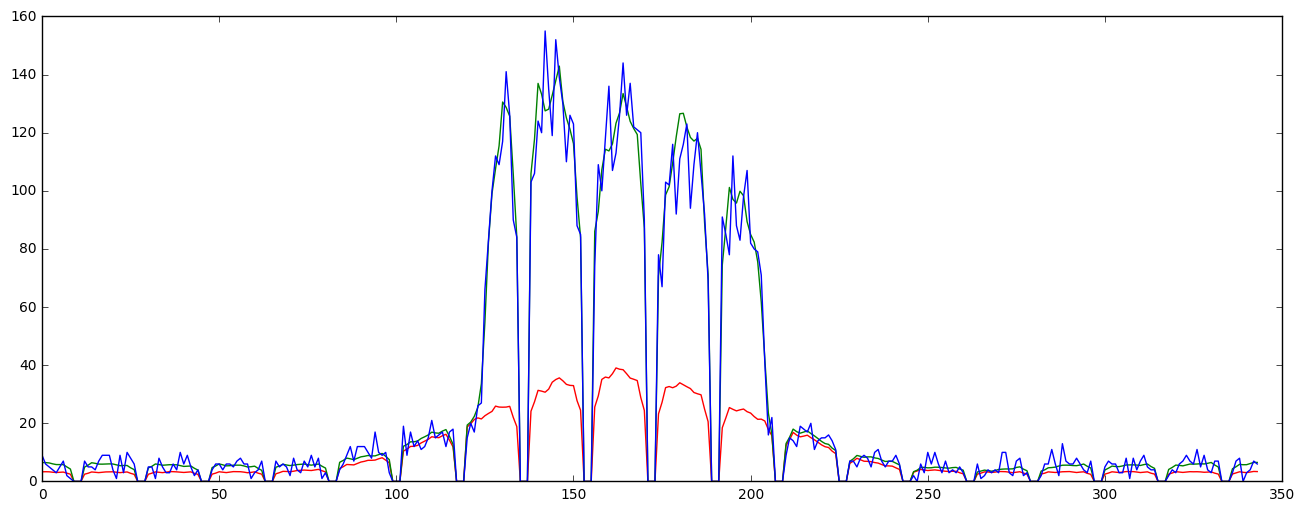

In [14]:
figure(figsize=[16,6]); hold(1)
plot(pet.randoms.data[126,8,:,70] + pet.scatter.data[126,8,:,70]*pet.sensitivity.data[126,8,:,70],'r'); 
plot(prompts.data[126,8,:,70],'g');
plot(pet.prompts.data[126,8,:,70],'b');

In [15]:
Nx = 344
Ny = 344
Nz = 127
pet.set_activity_shape([Nx,Ny,Nz])
pet.set_activity_size([2.08626*Nx, 2.08626*Ny, 2.03125*Nz])

In [16]:
activity_recon = pet.osem_reconstruction(iterations=150, subset_mode="ordered_axial", subset_size=12, 
                                   attenuation_projection=attenuation_projection) 

0 / 150
1 / 150
5 / 150
10 / 150
15 / 150
20 / 150
25 / 150
30 / 150
35 / 150
40 / 150
45 / 150
50 / 150
55 / 150
60 / 150
65 / 150
70 / 150
75 / 150
80 / 150
85 / 150
90 / 150
95 / 150
100 / 150
105 / 150
110 / 150
115 / 150
120 / 150
125 / 150
130 / 150
135 / 150
140 / 150
145 / 150
149 / 150


In [17]:
pet.prompts.save_to_file('%s/noisy_prompts.nii'%sim_path) 
activity_recon.save_to_file('%s/activity_recon.nii'%sim_path) 

In [18]:
activity_recon.max()

2.0532951

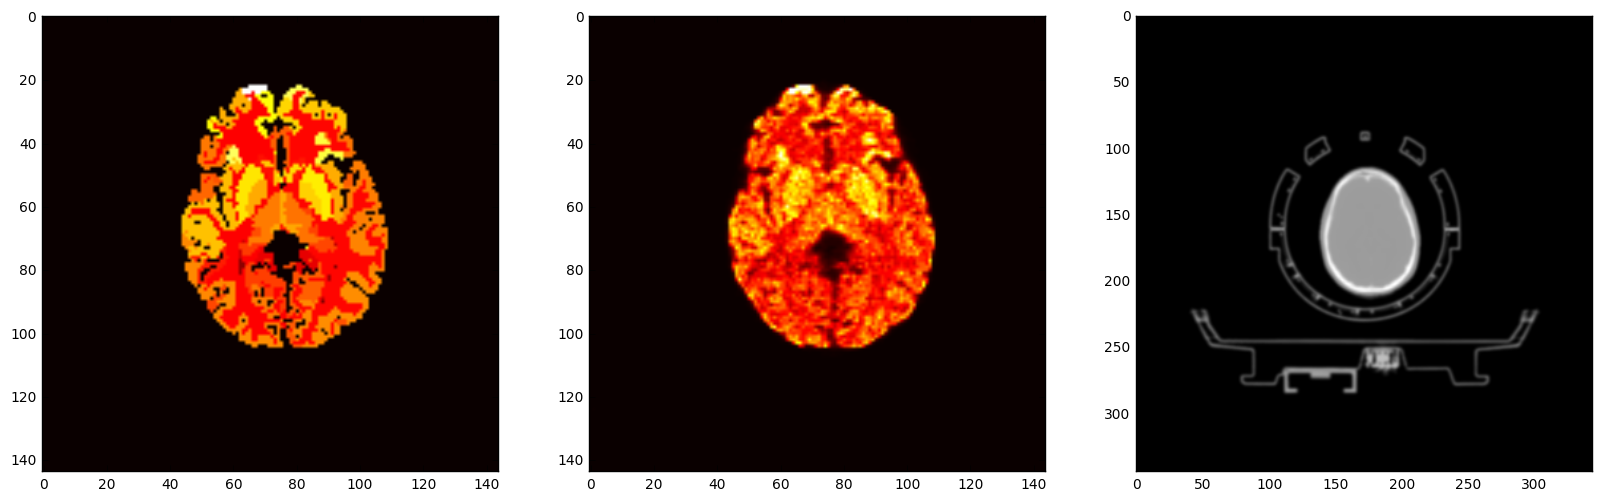

In [19]:
figure(figsize=[20,10]) 
subplot(1,3,1); imshow(flipud(true_activity.data[100:244,100:244,64]),cmap='hot',vmax=7.5) 
subplot(1,3,2); imshow(flipud(activity_recon.data[100:244,100:244,64])*pet.scale_activity/scale,cmap='hot',vmax=7.5) 
subplot(1,3,3); imshow(flipud(attenuation.data[:,:,64]),cmap='gray') 

7.69617 0.0355924
10.4799614269 0.0357170760683


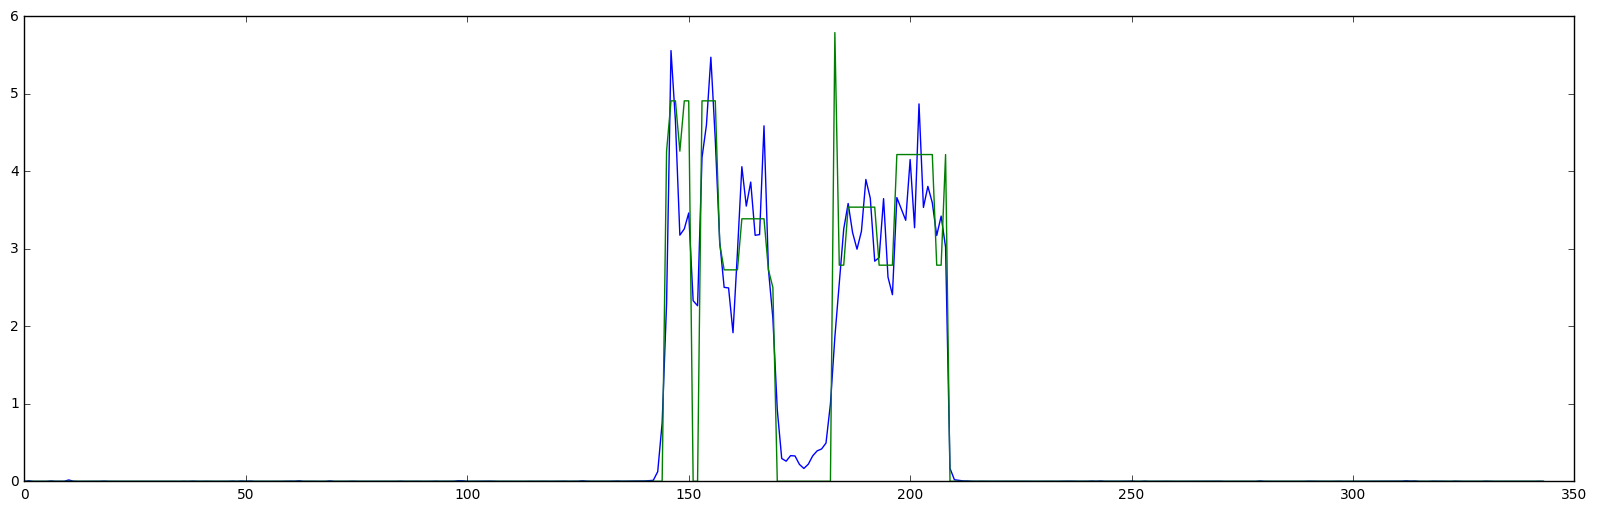

In [20]:
figure(figsize=[20,6])
plot(activity_recon.data[170,:,64]*pet.scale_activity/scale); 
hold(1); 
plot(true_activity.data[170,:,64]);
print true_activity.data.max(), true_activity.data.mean()
print activity_recon.data.max()*pet.scale_activity/scale, activity_recon.data.mean()*pet.scale_activity/scale